# Adaptive level equalization

This notebook defines the adaptive level equalization algorithm (on a spectrogram), as defined in Towsey 2013, for the removal of background noise from a recording of the natural acoustic environment. Towsey modified the algorithm first defined in Lamel et al. 1981, which was "originally used for end-point detection in speech recordings (Towsey 2013)."

[Towsey, Michael W. (2013)](http://eprints.qut.edu.au/61399/) Noise removal from wave-forms and spectrograms derived from natural recordings of the environment.

Lamel, L. F., Rabiner, L. R., Rosenberg, A. E., & Wilpon, J. G. (1981). An improved endpoint detector for isolated word recognition. IEEE Trans. ASSP, ASSP-29, 777-785.

#### Required packages

[scipy](https://github.com/scipy/scipy) <br />
[numpy](https://github.com/numpy/numpy) <br />
[pandas](https://github.com/pydata/pandas) <br />
[numba](https://github.com/numba/numba) <br />
[nacoustik](https://github.com/jacobdein/nacoustik) <br />
[matplotlib](https://github.com/matplotlib/matplotlib)

#### Import statements

In [43]:
import numpy as np
import pandas as pd
from numba import guvectorize, float64, int64
from nacoustik import Wave
from nacoustik.utilities import sum_decibels
from nacoustik.spectrum import psd
import matplotlib.pyplot as plt
%matplotlib inline

#### Variable declarations

sound — filepath, wavescape.Wave object, or numpy array of wave signal <br />
N — decimal value (0 - 1) to determine signal cutoff levels <br />
denoise_iterations — number of iterations to run the denoise algorithm

In [2]:
sound = "/Users/Jake/Desktop/seewave_examples/160317-145000_24k.wav"

In [3]:
N = 0.2

In [4]:
denoise_iterations = 4

## Compute spectrogram

load wave file and compute the psd spectrogram

f = frequency bins <br />
t = time steps <br />
a = amplitude values (decibels)

In [5]:
sound = Wave(sound)
sound.read()
sound.normalize()
f, t, a = psd(sound)

## Step A — Create a background-noise profile

1 – determine the number of histogram bins (1/8th of the total number of frequency bins in the spectrogram)

In [6]:
n_bins = np.round(a.shape[1] / 8).astype(np.int)
print("n_bins: {0}".format(n_bins))

n_bins: 63


2 – calculate histograms of intensity values for each frequency bin

In [7]:
# implemented as a universal function (ufunc) via numba.guvectorize
@guvectorize([(float64[:,:,:], int64[:], int64[:], float64[:,:,:], float64[:,:,:])], 
             '(c,f,t),(h),(e)->(c,f,h),(c,f,e)', nopython=True)
def calculate_histograms(a, h_bins, e_bins, hists, edges):
    for channel in range(a.shape[0]):
        for f_band in range(a.shape[1]):
            hists[channel, f_band], edges[channel, f_band] = np.histogram(a[channel, f_band], h_bins[0])

# allocate arrays for histograms and edge values
shape_histograms = (a.shape[0], a.shape[1], n_bins)
shape_edges = (a.shape[0], a.shape[1], n_bins + 1)
histograms = np.empty(shape_histograms)
edges = np.empty(shape_edges)

# call 'calculate_histograms' ufunc
histograms, edges = calculate_histograms(a, 
                                         # number of bins in histograms, as an array (hack)
                                         # necessary for numba.guvectorize function
                                         np.ones(shape=(n_bins), dtype=np.int64) * n_bins, 
                                         # number of histogram edges, as an array (hack)
                                         np.ones(shape=(n_bins + 1), dtype=np.int64) * (n_bins + 1), 
                                         histograms, edges)

3 — smooth the histograms with a moving average filter (window = 5) <br />
4 — determine the modal intensity of each histogram (the bin containing the most counts) <br />
5 — calculate the number of counts for one standard deviation (68%) of counts below the modal intensity <br />
6 — compute a signal cutoff value (values under which are noise) <br />

N — decimal value (0 - 1) to determine signal cutoff levels <br />
cutoff count = N \* total counts below modal intensity \* 68% <br />
cutoff value = lower edge value of the cutoff bin, found by  <br />
accumulating bin counts from the left side of the histogram  <br />
until the cutoff count is reached

helper function to determine the cutoff bin

In [8]:
def find_cutoff_index(histogram, cutoff_count):
    cumsum = 0.0
    for index, value in histogram.iteritems():
        cumsum += value
        if cumsum >= cutoff_count:
            break
    return index

calculate cutoff values

In [9]:
# allocate array for cutoff values
cutoffs = np.empty(shape=(histograms.shape[0], histograms.shape[1]))
# loop through all histograms for each frequency band
for channel in range(a.shape[0]):
    for f_band in range(a.shape[1]):
        # convert histogram to pandas.Series (to use moving average function)
        histogram = pd.Series(histograms[channel, f_band])
        # smooth
        histogram = histogram.rolling(center=False, window=5).mean()
        # replace NaN values generated by moving average
        histogram.replace(np.NaN, 0, inplace=True)
        # determine
        cutoff_count = histogram[0:histogram.idxmax()].sum() * 0.68 * N
        cutoffs[channel, f_band] = edges[channel, f_band, find_cutoff_index(histogram, cutoff_count)]

plot cutoff values (channel 1)

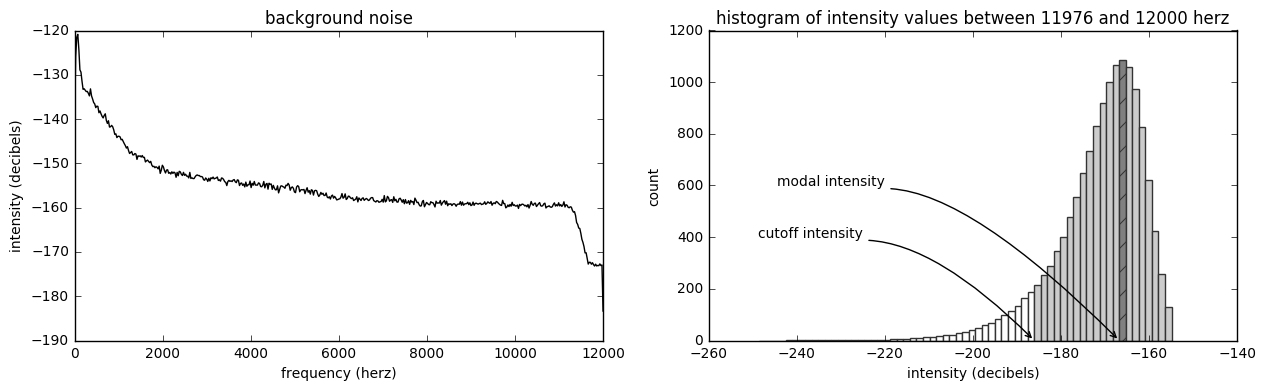

In [10]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)
# cutoff values over frequency for channel 1
pl = ax[0].plot(f, cutoffs[channel], color='black')
tl = ax[0].set_title('background noise')
xl0 = ax[0].set_xlabel('frequency (herz)')
yl0 = ax[0].set_ylabel('intensity (decibels)')
# smoothed histogram for the last (highest) frequency band in channel 1
width = edges[0, -1, 1] - edges[0, -1, 0]
pr = ax[1].bar(edges[0, -1, :-1], histogram.values, width=width, 
              color='0.8', edgecolor='0.2')
# annotate
bars = pr.get_children()
modal_bin = bars[histogram.idxmax()]
modal_bin.set_facecolor('0.5')
modal_bin.set_hatch('/')
cutoff_index = find_cutoff_index(histogram, cutoff_count)
cutoff_bin = bars[cutoff_index]
for i in range(cutoff_index):
    b = bars[i]
    b.set_facecolor('white')
tr = ax[1].set_title("histogram of intensity values between {0:.0f} and {1:.0f} herz".format(f[-2], f[-1]))
xl1 = ax[1].set_xlabel('intensity (decibels)')
yl1= ax[1].set_ylabel('count')
a1 = ax[1].annotate("modal intensity", xy=(modal_bin.get_x(), 0), xytext=(-220, 600), ha='right',
                    arrowprops=dict(arrowstyle='->', 
                                    connectionstyle='angle3,angleA=0,angleB=-45', 
                                    relpos=(1., 0.)))
a2 = ax[1].annotate("cutoff intensity", xy=(cutoff_bin.get_x(), 0), xytext=(-225, 400), ha='right',
                    arrowprops=dict(arrowstyle='->', 
                                    connectionstyle='angle3,angleA=0,angleB=-45', 
                                    relpos=(1., 0.)))

## Step B — Subtract cutoff values

1 — smooth cutoff values

In [11]:
#cutoffs_smooth = np.empty(shape=cutoffs.shape)
for channel in range(a.shape[0]):
    smoothed = pd.Series(cutoffs[channel]).rolling(center=False, window=5).mean()
    # replace NaN values
    smoothed.replace(np.NaN, smoothed.max(), inplace=True)
    cutoffs[channel] = smoothed.values

plot smoothed cutoff values

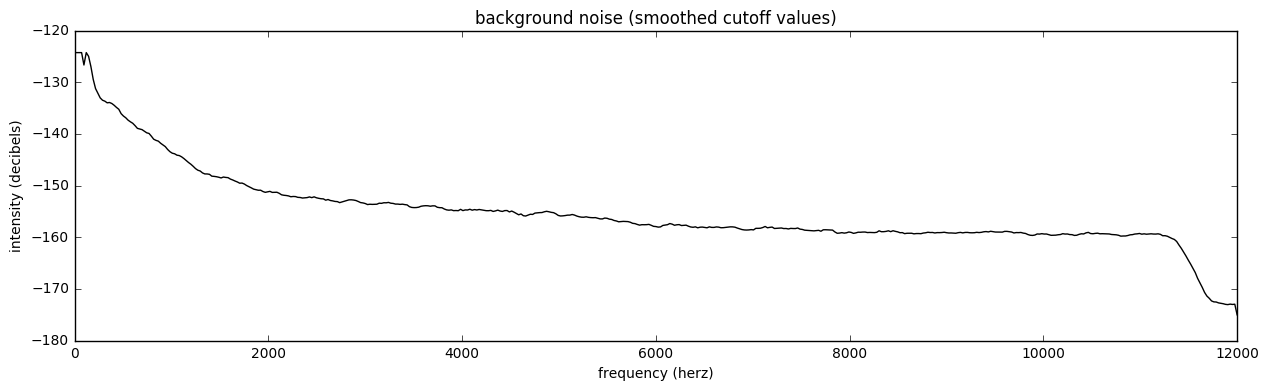

In [12]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
# cutoff values over frequency for channel 1
pl = ax.plot(f, cutoffs[channel], color='black')
tl = ax.set_title('background noise (smoothed cutoff values)')
xl0 = ax.set_xlabel('frequency (herz)')
yl0 = ax.set_ylabel('intensity (decibels)')

2 — subtract the cutoff values from the psd value for each frequency band

In [13]:
ale = np.empty_like(a)
it = np.nditer([cutoffs], flags=['c_index', 'multi_index'], op_flags=[['readonly']])
while not it.finished:
    ale[it.multi_index[0], it.multi_index[1]] = a[it.multi_index[0], it.multi_index[1]] - it.value
    it.iternext()

set all negative values to zero

In [14]:
ale = np.select(condlist=[ale > 0], choicelist=[ale], default=0)

## Step C — Denoise

"We implement an additional noise removal step to compensate for setting N to a small value in step A.6. This technique better preserves the structural integrity of complex acoustic events (e.g. bird calls) but removes noise from background locations further removed from that event. (Towsey 2013)"

1 — iterate over the all values in the spectrogram and compute the average value of the neighborhood (3 time steps x 9 frequency bins) <br />
2 — if the average is below a specified threshold (10), set the current value to the minimum of the neighborhood

refer to the profiling [results](https://github.com/jacobdein/alpine-soundscapes/blob/master/profiling/Denoise%20algorithm.ipynb) of the denoise algorithm

In [15]:
# implemented as a universal function via numba.guvectorize
@guvectorize([(float64[:,:,:], float64[:,:,:])], '(c,f,t)->(c,f,t)', nopython=True)
def denoise(a, b):
    for channel in range(2):
        for f_band in range(4, a.shape[1] - 4):
            for t_step in range(1, a.shape[2] - 1):
                neighborhood = a[channel, f_band - 4:f_band + 5, t_step - 1:t_step + 2]
                if neighborhood.mean() < 10:
                    b[channel, f_band, t_step] = neighborhood.min()
                else:
                    b[channel, f_band, t_step] = neighborhood[4, 1]

In [16]:
for i in range(denoise_iterations):
    ale = denoise(ale, np.zeros_like(ale))

plot result (channel 1)

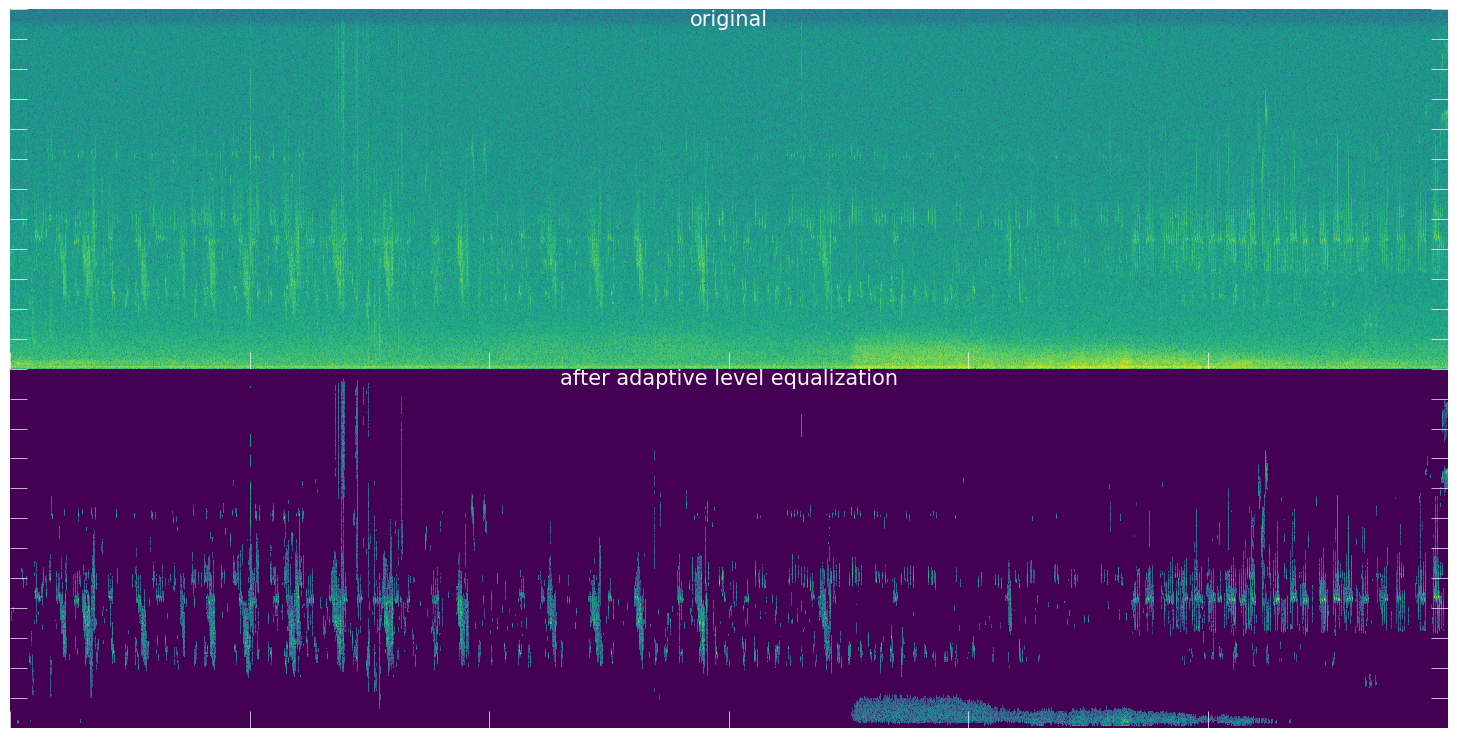

In [17]:
# configure figure
dpi = 192
fig = plt.figure(figsize=((920 / dpi) * 3, (460 / dpi) * 3), dpi=dpi)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_frameon(False)

# specify frequency bins (width of 1 kiloherz)
bins = np.arange(0, (sound.rate / 2), 1000)

# original
ax_spec_1 = plt.subplot(211)
spec_1 = ax_spec_1.pcolormesh(t, f, a[0], cmap='viridis')
ax_spec_1.set(ylim=([0, sound.rate / 2]),
              #xticks = np.arange(30, sound.duration, 30).astype(np.int),
              yticks = bins.astype(np.int) + 1000)
ax_spec_1.tick_params(length=12, color='white',
                      bottom=True, labelbottom=False,
                      top=False, labeltop=False,
                      labelleft=False,
                      labelright=False)
ax_spec_1.set_frame_on(False)

# after adaptive level equalization
ax_spec_2 = plt.subplot(212)
spec_2 = ax_spec_2.pcolormesh(t, f, ale[0], cmap='viridis')
ax_spec_2.set(ylim=([0, sound.rate / 2]),
              #xticks = np.arange(30, sound.duration, 30).astype(np.int),
              yticks = bins.astype(np.int) + 1000)
ax_spec_2.tick_params(length=12, color='white',
                      bottom=True, labelbottom=False,
                      top=False, labeltop=False,
                      labelleft=False,
                      labelright=False)
ax_spec_2.set_frame_on(False)

# annotation
t1 = ax_spec_1.text(sound.duration/2, sound.rate/2, 'original', color='white', 
                   ha='center', va='top', size=15)
t2 = ax_spec_2.text(sound.duration/2, sound.rate/2,
                    "after adaptive level equalization", color='white', 
                    ha='center', va='top', size=15)

## Step D — Replace original values

In [133]:
def subtract_decibels(a, b):
    return 10 * np.log10((10**(a / 10)) - (10**(b / 10)))

In [134]:
mask = np.ma.masked_not_equal(ale, value=0).mask
a_mask = a * mask
it = np.nditer([cutoffs], flags=['c_index', 'multi_index'], op_flags=[['readonly']])
while not it.finished:
    a_mask[it.multi_index[0], it.multi_index[1]] = subtract_decibels(a_mask[it.multi_index[0], it.multi_index[1]], it.value)
    it.iternext()
ale = a_mask * mask

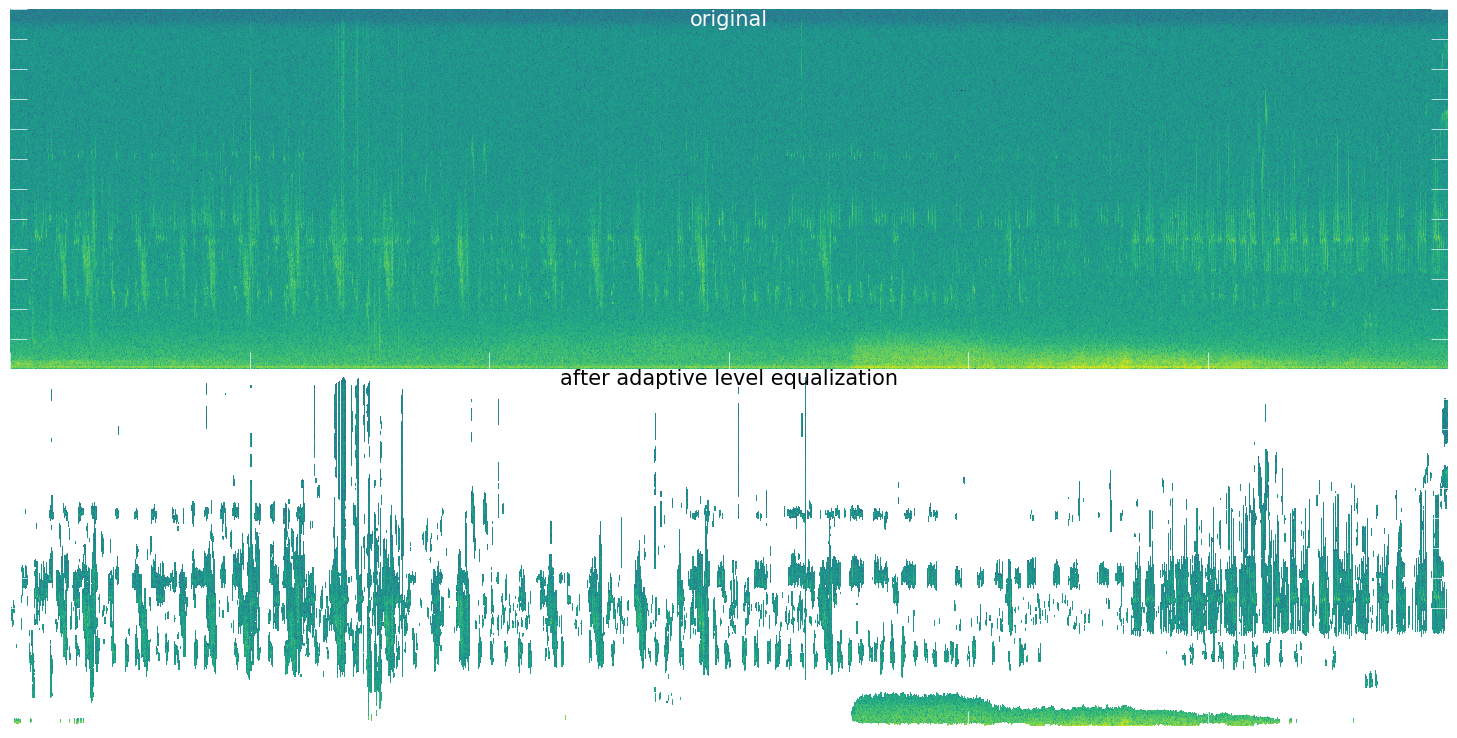

In [135]:
# configure figure
dpi = 192
fig = plt.figure(figsize=((920 / dpi) * 3, (460 / dpi) * 3), dpi=dpi)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_frameon(False)

# specify frequency bins (width of 1 kiloherz)
bins = np.arange(0, (sound.rate / 2), 1000)

# original
ax_spec_1 = plt.subplot(211)
spec_1 = ax_spec_1.pcolormesh(t, f, a[0], cmap='viridis')
ax_spec_1.set(ylim=([0, sound.rate / 2]),
              #xticks = np.arange(30, sound.duration, 30).astype(np.int),
              yticks = bins.astype(np.int) + 1000)
ax_spec_1.tick_params(length=12, color='white',
                      bottom=True, labelbottom=False,
                      top=False, labeltop=False,
                      labelleft=False,
                      labelright=False)
ax_spec_1.set_frame_on(False)

# after adaptive level equalization
ax_spec_2 = plt.subplot(212)
spec_2 = ax_spec_2.pcolormesh(t, f, np.ma.masked_equal(ale[0], 0), cmap='viridis', )
ax_spec_2.set(ylim=([0, sound.rate / 2]),
              #xticks = np.arange(30, sound.duration, 30).astype(np.int),
              yticks = bins.astype(np.int) + 1000)
ax_spec_2.tick_params(length=12, color='white',
                      bottom=True, labelbottom=False,
                      top=False, labeltop=False,
                      labelleft=False,
                      labelright=False)
ax_spec_2.set_frame_on(False)

# annotation
t1 = ax_spec_1.text(sound.duration/2, sound.rate/2, 'original', color='white', 
                   ha='center', va='top', size=15)
t2 = ax_spec_2.text(sound.duration/2, sound.rate/2,
                    "after adaptive level equalization", color='black', 
                    ha='center', va='top', size=15)